In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional, Input, Dot, Activation, Concatenate, Permute, Flatten, RepeatVector, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from pandas_ta.momentum import rsi
from pandas_ta.volatility import bbands
from pandas_ta.volatility import donchian
from pandas_ta.overlap import supertrend

In [63]:
class myLSTM:
    def __init__(self,path=r'D:\binanceapi\MarketData\BTCUSDT\BTCUSDT_1m.csv',n_steps=60):
        # Load your dataset
        self.df = pd.read_csv(path)
        self.step_size = n_steps
        """
        dc=donchian(self.df["High"],self.df["Low"],upper_length=self.step_size, lower_length=self.step_size)
        bbands_signal = bbands(self.df["Close"],length=self.step_size)
        rsi_sig = rsi(self.df["Close"],lenght=self.step_size)
        super_trend= supertrend(self.df["High"],self.df["Low"],self.df["Close"],self.step_size)
        self.df = pd.concat([self.df, dc,bbands_signal,rsi_sig,super_trend], axis=1)
        """
        
        # Convert timestamps if necessary
        self.df['Open Time'] = pd.to_datetime(self.df['Open Time'])
        self.df['Close Time'] = pd.to_datetime(self.df['Close Time'])
        # Drop or convert the timestamp columns since LSTM cannot process datetime directly
        self.df = self.df.drop(['Open Time', 'Close Time'], axis=1)
        # Compute returns
        
        self.df['Returns'] = (self.df['Close'] / self.df['Close'].shift(1))
        self.raw_close_prices = self.df["Close"]
        self.df = self.df.drop(["Close","High","Low","Open"],axis=1)
        # Drop the first row with NaN return value
        self.df = self.df.dropna()
        

        # Feature scaling
        self.X_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
        self.scaled_y = self.y_scaler.fit_transform(self.df["Returns"].values.reshape(-1,1))
        self.df = self.df.drop(["Returns"],axis = 1)
        self.scaled_X = self.X_scaler.fit_transform(self.df)


    # Prepare the data for LSTM
    def create_dataset(self):
        
        X, y = [], []
        for i in range(self.scaled_X.shape[0] - self.step_size):
            X.append(self.scaled_X[i:i + self.step_size])
            y.append(self.scaled_y[i + self.step_size])  # Assuming 'Returns' is the last column

        self.preprocessed_X = np.array(X)
        self.preprocessed_y = np.array(y)
    
    def train_test_split(self,split_ratio = 0.8):
        # Train-test split
        split = int(self.scaled_X.shape[0] * split_ratio)
        self.split = split
        self.X_train, self.X_test = self.preprocessed_X[:split], self.preprocessed_X[split:]
        self.y_train, self.y_test = self.preprocessed_y[:split], self.preprocessed_y[split:]
    
    # Define the model with attention mechanism
    def build_model(self):
        inputs = Input(shape=(self.step_size, self.X_train.shape[2]))
        lstm_out1 = LSTM(120,return_sequences = True)(inputs)
        lstm_out2 = LSTM(60)(lstm_out1)
        output = Dense(1)(lstm_out2)
        model = Model(inputs=inputs, outputs=output)
        model.compile(optimizer='adam', loss='mean_absolute_error')
        self.model = model
    
    def train(self,epochs_in = 100,batch_size_in=32,validation_split_in=0.2):
        # Early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        # Train the model
        self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs_in, batch_size=batch_size_in, validation_split=validation_split_in, callbacks=[early_stopping])
    
    def generate_inverse(self):
        y_pred = self.model.predict(self.X_test)
        # Inverse transform the predictions and actual values to original scale
        y_test_inv = (self.y_test * self.y_scaler.var_) + self.y_scaler.mean_ 
        self.y_pred_inv = (y_pred * self.y_scaler.var_) + self.y_scaler.mean_ 
        self.y_test_inv = y_test_inv.reshape(-1,1)
    
    def generate_inverse2(self):
        y_pred = self.model.predict(self.X_test)
        # Inverse transform the predictions and actual values to original scale
        y_test_inv = self.y_scaler.inverse_transform(self.y_test)
        self.y_pred_inv = self.y_scaler.inverse_transform(y_pred)
        self.y_test_inv = y_test_inv.reshape(-1, 1)
    
    def plot_returns(self):
        # Ensure both arrays have the same shape
        self.generate_inverse2()
        assert self.y_test_inv.shape == self.y_pred_inv.shape, "Shapes of y_test_inv and y_pred_inv don't match"

        # Plot actual vs predicted returns
        plt.figure(figsize=(12, 6))
        plt.plot(self.y_test_inv, label='Actual Returns')
        plt.plot(self.y_pred_inv, label='Predicted Returns')
        plt.title('Actual vs Predicted Returns with Attention Mechanism')
        plt.xlabel('Time')
        plt.ylabel('Returns')
        plt.legend()
        plt.show()
        # Compute and print mean absolute error (MAE)
        mae = mean_absolute_error(self.y_test_inv, self.y_pred_inv)
        self.mae_score = mae
        print("Mean Absolute Error (MAE):", mae)

    def returns_to_close_predictions(self):
        self.generate_inverse2()
        starting_price = self.raw_close_prices.loc[self.split + self.step_size]
        print_list = []
        c=0
        for pred in self.y_pred_inv:
            if print_list == []:
                print_list.append(pred * starting_price)
            else:
                print_list.append(pred * print_list[c])
                c = c+1
        return np.array(print_list)
        
    def plot_predictions(self):
        pred_list = self.returns_to_close_predictions()
        
        # Plot actual and predicted close prices
        plt.figure(figsize=(12, 6))
        plt.plot(self.raw_close_prices.loc[self.split+self.step_size+1:].index, self.raw_close_prices.loc[self.split+self.step_size+1:], label='Actual Close Price')
        plt.plot(self.raw_close_prices.loc[self.split+self.step_size+1:].index, pred_list, label='Predicted Close Price')
        plt.title('Actual vs Predicted Close Prices')
        plt.xlabel('Time')
        plt.ylabel('Close Price')
        plt.legend()
        plt.show()

In [64]:
mLstm = myLSTM(n_steps= 120)
mLstm.create_dataset()
mLstm.train_test_split()
mLstm.build_model()

In [65]:
mLstm.train()

Epoch 1/100
3657/3657 ━━━━━━━━━━━━━━━━━━━━ 203s 55ms/step - loss: 0.5508 - val_loss: 0.8953
Epoch 2/100
3657/3657 ━━━━━━━━━━━━━━━━━━━━ 204s 56ms/step - loss: 0.5480 - val_loss: 0.8955
Epoch 3/100
3657/3657 ━━━━━━━━━━━━━━━━━━━━ 203s 56ms/step - loss: 0.5470 - val_loss: 0.8953
Epoch 4/100
3657/3657 ━━━━━━━━━━━━━━━━━━━━ 206s 56ms/step - loss: 0.5478 - val_loss: 0.8953
Epoch 5/100
3657/3657 ━━━━━━━━━━━━━━━━━━━━ 209s 57ms/step - loss: 0.5468 - val_loss: 0.8953
Epoch 6/100
3657/3657 ━━━━━━━━━━━━━━━━━━━━ 194s 53ms/step - loss: 0.5497 - val_loss: 0.8951
Epoch 7/100
1770/3657 ━━━━━━━━━━━━━━━━━━━━ 1:41 54ms/step - loss: 0.5462

KeyboardInterrupt: 

1139/1139 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step


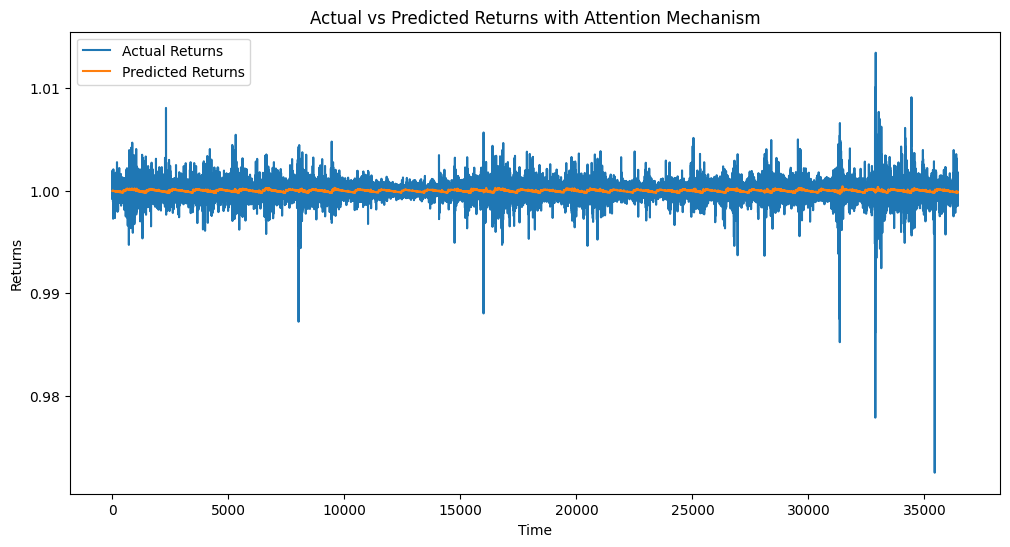

Mean Absolute Error (MAE): 0.0005567031680366105


In [41]:
mLstm.plot_returns()

1139/1139 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step


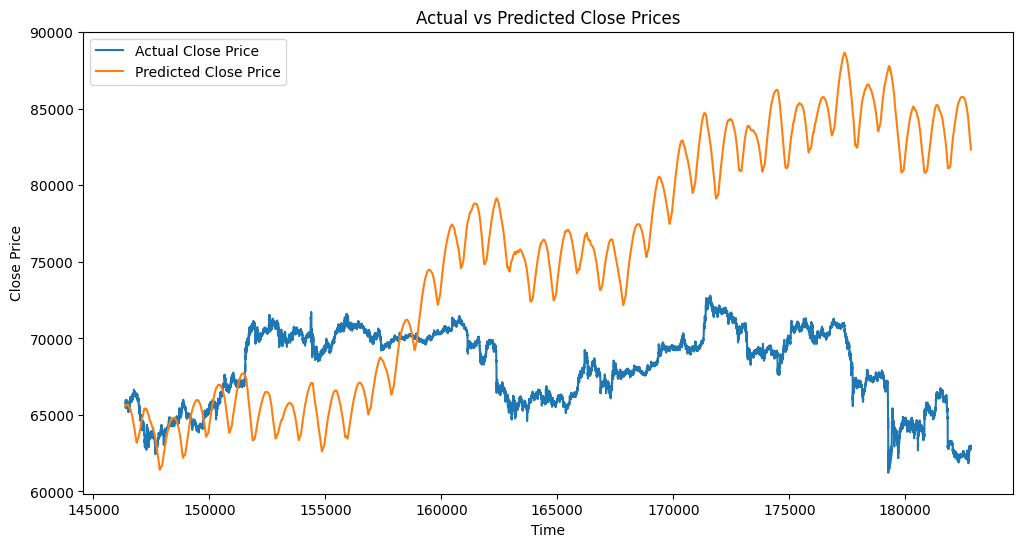

In [59]:
mLstm.plot_predictions()

In [51]:
pL = mLstm.returns_to_close_predictions()

1139/1139 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step


In [52]:
pL.shape

(36446, 1)